In [13]:
import numpy as np
import pandas as pd
from pathlib import Path
import yaml
from support_functions import load_dictionaries
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
df_real = pd.read_excel("Data/"+"real_data.xlsx", index_col=0)


with open("Config/config_file.yml", "r") as ymlfile:
    cfg = yaml.safe_load(ymlfile)
day_of_the_week = cfg["day_of_the_week"]
cost_euro_x_Km = cfg["cost_euro_x_Km"]
solution_to_analize = cfg["solution_to_analize"]
df_real = df_real[df_real[day_of_the_week].notna()]


df_our_model_solution = pd.read_excel("Results/"+solution_to_analize, index_col=0)  #sta in questo file solo per fare il confonto AMA vs OUR (i plot in "AMA solution vs our solution: a visual comparison")
df_ama_solution = df_real[["service_id", "material", "preferred_autocenter", "vehicle", "preferred_facility_desc", "preferred_facility_id", "quantity(kg)"]].rename(columns = {"preferred_autocenter": "vehicle_autocenter","vehicle":"vehicle_type", "preferred_facility_id":"facility_id", "quantity(kg)":"service_quantity(kg)"})

In [15]:
df_ama_solution

,service_id,material,vehicle_autocenter,vehicle_type,preferred_facility_desc,facility_id,service_quantity(kg)
0,13B22P,rifiuto indifferenziato,AUTO_AC,COMP 2A,TMB MALAGROTTA 1/2 (RIFIUTO INDIFFERENZIATO),IMP_000010_0011,1280
1,M12AR01,rifiuto indifferenziato,AUTO_AC,COMP SIDE LOA 3A,TMB MALAGROTTA 1/2 (RIFIUTO INDIFFERENZIATO),IMP_000010_0011,6020
3,M12AR01N,rifiuto indifferenziato,AUTO_AC,COMP SIDE LOA 3A,TMB MALAGROTTA 1/2 (RIFIUTO INDIFFERENZIATO),IMP_000010_0011,6370
4,M12AS02,rifiuto indifferenziato,AUTO_AC,COMP SIDE LOA 3A,TMB MALAGROTTA 1/2 (RIFIUTO INDIFFERENZIATO),IMP_000010_0011,7350
6,M12BI03,rifiuto indifferenziato,AUTO_AC,COMP SIDE LOA 3A,TMB MALAGROTTA 1/2 (RIFIUTO INDIFFERENZIATO),IMP_000010_0011,6510
...,...,...,...,...,...,...,...
805,04RD01-CA,rifiuto rd carta,AUTO_SA,COMP SIDE LOA 3A,ROMANA MACERI (RIFIUTO RD CARTA),IMP_000016_0013,5580
808,04RD04-CAB,rifiuto rd carta,AUTO_SA,COMP SIDE LOA 3A,ROMANA MACERI (RIFIUTO RD CARTA),IMP_000016_0013,5340
810,04RD06-CAB,rifiuto rd carta,AUTO_SA,COMP SIDE LOA 3A,ROMANA MACERI (RIFIUTO RD CARTA),IMP_000016_0013,4680
814,04RD10-CAB,rifiuto rd carta,AUTO_SA,COMP SIDE LOA 3A,ROMANA MACERI (RIFIUTO RD CARTA),IMP_000016_0013,5460


In [16]:
##   We need df_depots for the following computations
df_depots = pd.read_excel('Data/real_data.xlsx',sheet_name='Depot',index_col=0)
df_depots.fillna(0,inplace=True)
vehicle_per_depot = df_depots[["vehicle"]]
vehicles_per_depot_list = []
for depot_id in vehicle_per_depot.index:
    depot_dic = eval(vehicle_per_depot[vehicle_per_depot.index==depot_id]["vehicle"][depot_id])
    for key in depot_dic.keys():
        template_row = [depot_id, key, depot_dic[key]]
        vehicles_per_depot_list.append(template_row)
df_vehicle_per_depot = pd.DataFrame(vehicles_per_depot_list, columns = ["vehicle_autocenter", "vehicle_type", "available"])
df_vehicle_per_depot.head(5)


,vehicle_autocenter,vehicle_type,available
0,AUTO_AC,COMP 2A,14
1,AUTO_AC,COMP 3A,14
2,AUTO_AC,COMP SIDE LOA 2A,2
3,AUTO_AC,COMP SIDE LOA 3A,21
4,AUTO_PM,COMP 2A,35


In [17]:
# df_depots = pd.read_excel('Data/real_data.xlsx',sheet_name='Depot')['depot_id']
# df_services = pd.read_excel('Data/real_data.xlsx',sheet_name='Service',index_col=0)
# df_services = df_services[df_services[day_of_the_week].notna()]['service_id']
# df_disposals = pd.read_excel('Data/real_data.xlsx',sheet_name='Disposal')['disposal_id']
# df_tranships = pd.read_excel('Data/real_data.xlsx',sheet_name='Transship')['transhipment_id']
# df = pd.concat([df_depots, df_services, df_disposals, df_tranships])
# df = df.reset_index(drop=True)
# nodeid_to_grbid_dict = pd.Series(df.index.values, index= df ).to_dict()
# nodeid_to_grbid_dict

In [18]:
dis_dict, dur_dict = load_dictionaries()

dis. & dur. dictionaries have been loaded


In [19]:
with open("Config/config_file.yml", "r") as ymlfile:
    cfg = yaml.safe_load(ymlfile)



In [20]:
df_ama_solution.head()

,service_id,material,vehicle_autocenter,vehicle_type,preferred_facility_desc,facility_id,service_quantity(kg)
0,13B22P,rifiuto indifferenziato,AUTO_AC,COMP 2A,TMB MALAGROTTA 1/2 (RIFIUTO INDIFFERENZIATO),IMP_000010_0011,1280
1,M12AR01,rifiuto indifferenziato,AUTO_AC,COMP SIDE LOA 3A,TMB MALAGROTTA 1/2 (RIFIUTO INDIFFERENZIATO),IMP_000010_0011,6020
3,M12AR01N,rifiuto indifferenziato,AUTO_AC,COMP SIDE LOA 3A,TMB MALAGROTTA 1/2 (RIFIUTO INDIFFERENZIATO),IMP_000010_0011,6370
4,M12AS02,rifiuto indifferenziato,AUTO_AC,COMP SIDE LOA 3A,TMB MALAGROTTA 1/2 (RIFIUTO INDIFFERENZIATO),IMP_000010_0011,7350
6,M12BI03,rifiuto indifferenziato,AUTO_AC,COMP SIDE LOA 3A,TMB MALAGROTTA 1/2 (RIFIUTO INDIFFERENZIATO),IMP_000010_0011,6510


## Kilometers

In [21]:
total_dis = 0
for index,row in df_ama_solution.iterrows():
    total_dis += dis_dict[row['vehicle_autocenter'],row['service_id']]
    total_dis += dis_dict[row['service_id'],row['facility_id']]
    total_dis += dis_dict[row['facility_id'],row['vehicle_autocenter']]

total_dis = np.round(total_dis, 2)

print("AMA objective function value is: ", total_dis*cost_euro_x_Km)
print("kilometers of AMA solution: ", total_dis)

AMA objective function value is:  21861.792
kilometers of AMA solution:  24290.88


## AMA solution vs our solution: a visual comparison

In [22]:
service_time_ama_dict = {}
service_km_ama_dict = {}

service_time_our_dict = {}   #trovare nome più carino
service_km_our_dict = {}

df_our_model_solution


for index,row in df_ama_solution.iterrows():
    service_id = row['service_id']
    v_autocenter = row['vehicle_autocenter']
    facility_id = row['facility_id']
    service_km_ama_dict[service_id] = dis_dict[v_autocenter, service_id] + dis_dict[service_id, facility_id]+dis_dict[facility_id, v_autocenter]
    service_time_ama_dict[service_id] = dur_dict[v_autocenter, service_id] + dur_dict[service_id, facility_id]+dur_dict[facility_id, v_autocenter]

for index,row in df_our_model_solution.iterrows():
    service_id = row['service_id']
    v_autocenter = row['vehicle_autocenter']
    facility_id = row['facility_id']
    service_km_our_dict[service_id] = dis_dict[v_autocenter, service_id] + dis_dict[service_id, facility_id]+dis_dict[facility_id, v_autocenter]
    service_time_our_dict[service_id] = dur_dict[v_autocenter, service_id] + dur_dict[service_id, facility_id]+dur_dict[facility_id, v_autocenter]

In [24]:
#### Prendo i km per segmento e li confronto con quelli che si trovano in Formulation v1 (ANALYZE SOLUTION, check km, detail per segment)
#### NB! i dizionari sono diversi, uno prende gli indici (quello di form_v1) e l'altro invece gli ID veri.
#### SOSPETTO: la creazione di "d" (nella formulazione v1) potrebbe essere sbagliata.
km_as = 0
km_sf = 0
km_fa = 0

for index,row in df_our_model_solution.iterrows():
    service_id = row['service_id']
    v_autocenter = row['vehicle_autocenter']
    facility_id = row['facility_id']
    km_as += dis_dict[v_autocenter, service_id]
    km_sf += dis_dict[service_id, facility_id]
    km_fa += dis_dict[facility_id, v_autocenter]

print("km as", km_as)
print("km sf", km_sf)
print("km fa", km_fa)
print("sum km:", km_as+km_sf+km_fa)

km as 6887.891600000005
km sf 7780.721199999997
km fa 2093.4134000000035
sum km: 16762.026200000008


In [26]:
ama_times = list(service_time_ama_dict.values())
ama_km = list(service_km_ama_dict.values())
our_times = list(service_time_our_dict.values())
our_km = list(service_km_our_dict.values())

print("total km in the ama solution: ", np.round(sum(ama_km),2))
print("total km in our solution: ", np.round(sum(our_km),2))

print("total time in the ama solution: ", np.round(sum(ama_times),2))
print("total time in our solution: ", np.round(sum(our_times),2))


total km in the ama solution:  24290.88
total km in our solution:  16762.03
total time in the ama solution:  686.13
total time in our solution:  517.3


<Figure size 432x288 with 0 Axes>

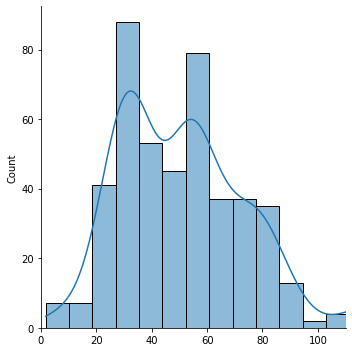

(0.0, 110.0)

<Figure size 432x288 with 0 Axes>

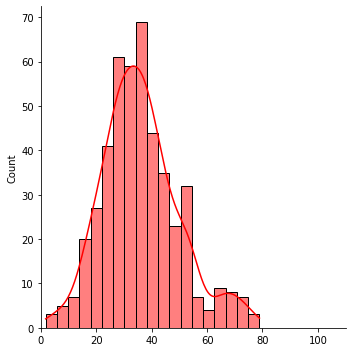

In [37]:
plt.clf()
sns.displot(x=ama_km, kde=True)
plt.xlim(0, 130)
plt.show()


plt.clf()
sns.displot(x=our_km, kde=True, color = 'r')
plt.xlim(0, 130)
plt.show()




<Figure size 432x288 with 0 Axes>

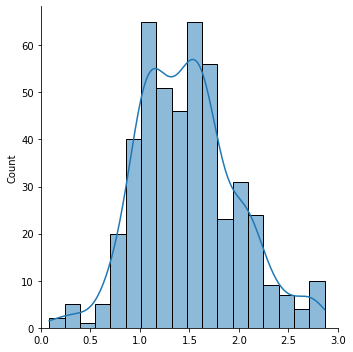

<Figure size 432x288 with 0 Axes>

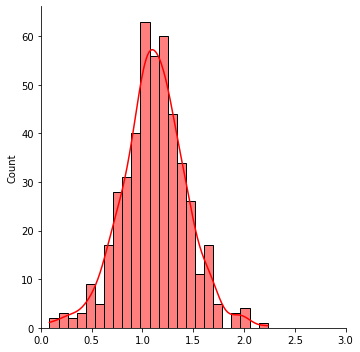

In [40]:
plt.clf()
sns.displot(x=ama_times, kde=True)
plt.xlim(0, 3)
plt.show()

plt.clf()
sns.displot(x=our_times, kde=True, color = 'r')
plt.xlim(0, 3)
plt.show()

## Vehicle usage

In [77]:
# - df_vehicle_per_depot_used: vehicle departed by each autocenter - vehicle_type detail
df_vehicle_per_depot_used = df_ama_solution.groupby(["vehicle_autocenter", "vehicle_type"], as_index=False).size().rename(columns = {'size': "used"})
df_vehicle_per_depot_used = df_vehicle_per_depot.merge(df_vehicle_per_depot_used, on=["vehicle_autocenter", "vehicle_type"], how = 'outer').fillna(0)
df_vehicle_per_depot_used["%"] = np.round((df_vehicle_per_depot_used["used"]/df_vehicle_per_depot_used["available"])*100,1)
df_vehicle_per_depot_used = df_vehicle_per_depot_used[["vehicle_autocenter", "vehicle_type", "used", "available", "%"]]
df_vehicle_per_depot_used["used"] = df_vehicle_per_depot_used["used"].astype(int)
df_vehicle_per_depot_used.head(10)

,vehicle_autocenter,vehicle_type,used,available,%
0,AUTO_AC,COMP 2A,1,14,7.1
1,AUTO_AC,COMP 3A,0,14,0.0
2,AUTO_AC,COMP SIDE LOA 2A,0,2,0.0
3,AUTO_AC,COMP SIDE LOA 3A,27,21,128.6
4,AUTO_PM,COMP 2A,27,35,77.1
5,AUTO_PM,COMP 3A,0,16,0.0
6,AUTO_PM,COMP SIDE LOA 2A,15,17,88.2
7,AUTO_PM,COMP SIDE LOA 3A,64,46,139.1
8,AUTO_RC,COMP 2A,6,31,19.4
9,AUTO_RC,COMP 3A,0,27,0.0


In [ ]:
# - df_vehicle_per_depot_used_agg: vehicle departed by each autocenter - aggregated
df_vehicle_per_depot_used_agg = df_ama_solution.groupby(["vehicle_autocenter"], as_index=False).size().rename(columns = {'size': "used"})
df_vehicle_per_depot_used_agg = pd.merge(df_vehicle_per_depot_used_agg, df_vehicle_per_depot.groupby("vehicle_autocenter")[['available']].agg(sum).reset_index())
df_vehicle_per_depot_used_agg["%"] = (df_vehicle_per_depot_used_agg["used"]/df_vehicle_per_depot_used_agg["available"]*100).round(1)
df_vehicle_per_depot_used_agg.head()

In [ ]:
## df_vehicle_qnt_kg_per_type: kg and number of services per vehicle type - vehicle_type detail
df_vehicle_qnt_kg_per_type = df_ama_solution.groupby(["vehicle_autocenter","vehicle_type"]).agg(s_count = ("service_id", "count"), mean_kg_per_s = ("service_quantity(kg)", "mean"), total_kg = ("service_quantity(kg)", "sum")).round(1)
df_vehicle_qnt_kg_per_type = df_vehicle_qnt_kg_per_type.join(df_vehicle_per_depot.groupby(["vehicle_autocenter","vehicle_type"])[["available"]].sum())
df_vehicle_qnt_kg_per_type["%"] = np.round(df_vehicle_qnt_kg_per_type["s_count"]/df_vehicle_qnt_kg_per_type["available"],2)*100
df_vehicle_qnt_kg_per_type = df_vehicle_qnt_kg_per_type[["s_count","available","%", "mean_kg_per_s", "total_kg"]]
df_vehicle_qnt_kg_per_type

In [ ]:
## df_vehicle_qnt_kg_per_type_agg: kg and number of services per vehicle type - aggregated
df_vehicle_qnt_kg_per_type_agg = df_ama_solution.groupby("vehicle_type").agg(s_count = ("service_id", "count"), mean_kg_per_s = ("service_quantity(kg)", "mean"), total_kg = ("service_quantity(kg)", "sum")).round(1)
df_vehicle_qnt_kg_per_type_agg = df_vehicle_qnt_kg_per_type_agg.join(df_vehicle_per_depot.groupby("vehicle_type")[["available"]].sum())
df_vehicle_qnt_kg_per_type_agg["%"] = np.round(df_vehicle_qnt_kg_per_type_agg["s_count"]/df_vehicle_qnt_kg_per_type_agg["available"],2)*100
df_vehicle_qnt_kg_per_type_agg = df_vehicle_qnt_kg_per_type_agg[["s_count","available","%", "mean_kg_per_s", "total_kg"]]
df_vehicle_qnt_kg_per_type_agg

## Facility usage

In [ ]:
## df_facility_results: kg and number of services per facility
df_facility_real = pd.read_excel("Data/real_data.xlsx", sheet_name= "Disposal", index_col=0)
df_facility_results = df_ama_solution.groupby("facility_id").agg(s_count = ("service_id", "count"), mean_kg_per_s = ("service_quantity(kg)", "mean"), total_kg = ("service_quantity(kg)", "sum")).round(1)
df_facility_results

In [ ]:
## Add 15% to the capacity and export dataframe
total_kg = df_facility_results['total_kg']
writer = pd.ExcelWriter(str(Path().resolve()) + '\\Data\\AMA_capacity.xlsx', engine='xlsxwriter')
total_kg.to_excel(writer, sheet_name='Capacity')
writer.save()

In [ ]:
#df_facility_summary = df_facility_real[["capacity(kg)", "material"]].join(df_facility_results)
#df_disposal_summary = df_facility_summary[["material", "s_count", "mean_kg_per_s", "total_kg", "capacity(kg)"]].fillna(0)
#df_facility_summary["%"] = (df_facility_summary["total_kg"]/df_facility_summary["capacity(kg)"]*100).round(2)
#df_facility_summary